In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt

%matplotlib notebook
np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True)

In [4]:
import os
import sys
sys.path.append(os.path.abspath('..'))

from utils import add_pi_ticks
from distributions import wrapped_normal, bernoulli, truncated_normal

### Wrapped Normal Distributions

In the biased-persistent random walk model, angles are drawn from a wrapped normal distribution defined by 

$$
\mathcal{N}^{\text{w}}(\alpha_{t}; \, \mu, \, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \sum_{k=-\infty}^{\infty} \exp \big( - \frac{(\alpha_{t} - \mu + 2 \pi k)^{2}}{2 \sigma ^{2}} \big)
$$

This essentially means the normal distribution lies on a plane with periodic boundary conditions

<IPython.core.display.Javascript object>


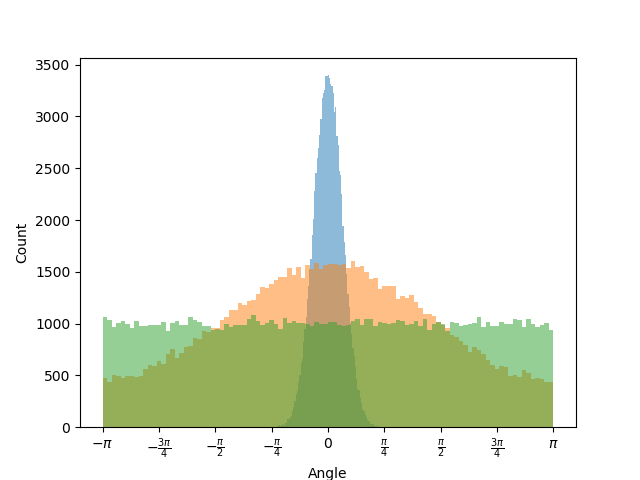

In [31]:
fig, ax = plt.subplots()
for sig in [0.2, 1.6, 100]:
    a = wrapped_normal(0, sig, 100000)
    plt.hist(a, bins=100, alpha=0.5)

add_pi_ticks(ax)
plt.xlabel('Angle')
plt.ylabel('Count')
plt.show()

<IPython.core.display.Javascript object>


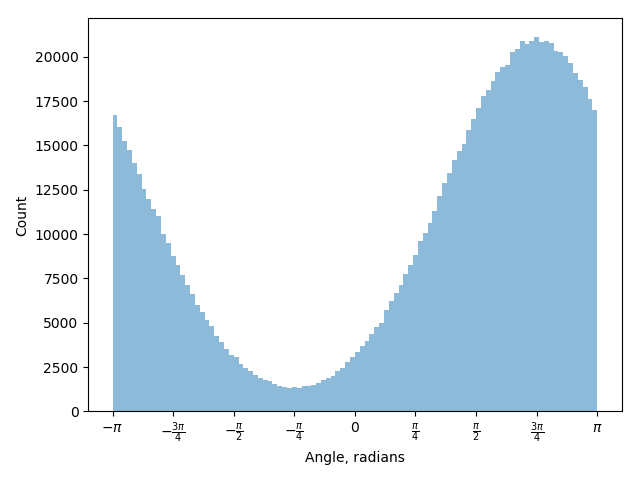

In [14]:
fig, ax = plt.subplots()
a = wrapped_normal(0.75 * np.pi, 1.2, 1000000) 
plt.hist(a, bins=100, alpha=0.5)
add_pi_ticks(ax)
plt.xlabel('Angle, radians')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('wrapped.pdf')
plt.show()

### Random Walk Models

Here we define a rough model for a wound. The chemical gradient is modeled to be guassian in shape, with a circular valley. The vector gradient at any point is used to derive the angle towards the source, $\beta$

<IPython.core.display.Javascript object>


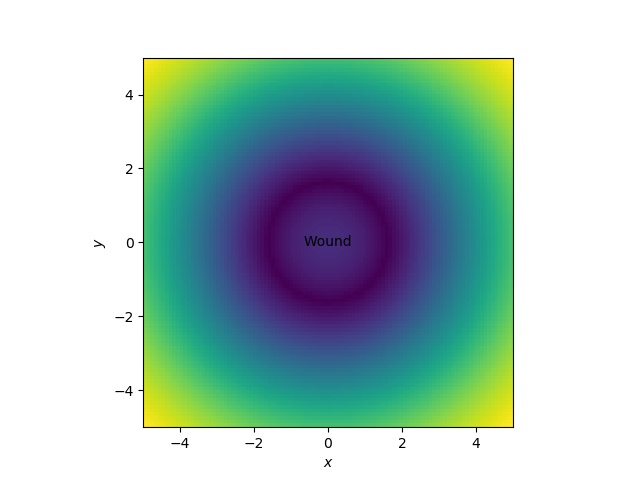

In [17]:
def f(x, y):
    """
    A toy chemical gradient landscape in 2D
    """
    return np.abs(0.9 - np.exp(- (x ** 2 + y ** 2) / 25))

def grad(coords):
    """
    Get the gradient of the landscape for a given (x, y) coordinate
    """
    x, y = coords
    f_ = np.exp(- (x ** 2 + y ** 2) / 25)
    if f_ < 0.9:
        return np.array([x * f_, y * f_])
    else:
        return -np.array([x * f_, y * f_])
    
x, y = np.linspace(-5, 5, 101), np.linspace(-5, 5, 101)
X, Y = np.meshgrid(x, y) 
    
def plot_wound():
    fig = plt.figure()
    plt.imshow(f(X, Y), extent=(-5, 5, -5, 5))
    plt.text(0, 0, "Wound", size=10, ha="center", va="center")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_wound()

In [18]:
def mag(vec):
    return (vec ** 2).sum() ** 0.5

def angle_between(v1, v2):
    """
    v1 is the reference vector. Angle is positive anti-clockwise, negative clockwise 
    between -pi and pi. 
    """
    dot = v1 @ v2
    det = v1[0] * v2[1] - v1[1] * v2[0]
    return np.arctan2(det, dot)

<img src="images/biased-persistent.png" width="400">

### A Random Walker

Each walker is defined by three parameters: $p, b$ and $w$ which all lie between 0 and 1. The walk goes something like this:

1. At each time step, generate a random number between 0 and 1. If this is less than $w$ we perform a biased step. If it is greater, we perform a persistent step. 
2. Set $\sigma = -2\log b$ if biased, and  $\sigma = -2\log p$ if persistent. 
3. Set $\mu = \beta_{t}$ if biased, and $\mu = \alpha_{t-1} $ if persistent. 
4. Draw a random angle from the wrapped normal distribution, $\mathcal{N}_{\text{w}}(\alpha_{t}; \, \mu, \, \sigma)$
5. Draw a random step from the truncated normal distribution $\mathcal{N}^{+}(s_{t}; \, 0, \, \sqrt{dt})$
6. Update the walker's coordinates and repeat. 

<IPython.core.display.Javascript object>


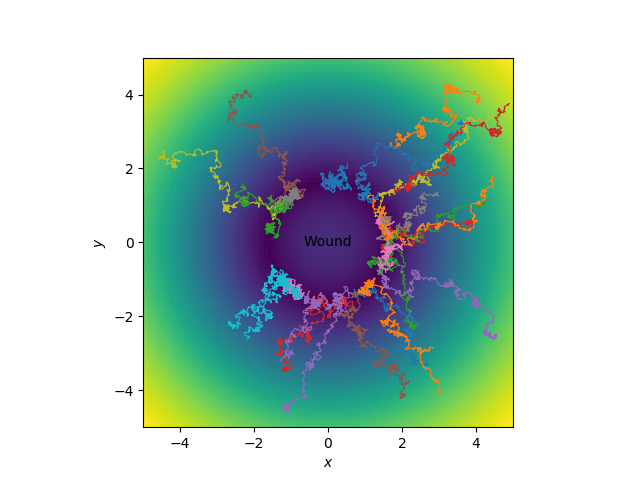

In [21]:
reference_axis = np.array([0, -1]) # use negative y-axis as the reference axis, as per the image

class Walker:
    """
    A random walker object
    """
    
    def __init__(self, w: float, p: float, b: float, start: tuple=(4, 4)) -> None:
        self.w = w
        self.p = p
        self.b = b
        self.init_coordinates = np.array(start)
        self.step_size = 1 / 20

    def walk(self, n_steps=500):
        """
        Take n_steps following a biased-persistent random walk
        """
        path = np.zeros((n_steps + 1, 2))    # to hold the x-y coordinates at each time step
        path[0, :] = self.init_coordinates
        biased = bernoulli(self.w, n_steps)  # pre-compute all the bernoulli random variables
        angle_history = []
        
        for i, bias in enumerate(biased):
            current_position = path[i]
            direction_to_source = - grad(current_position)   # -ve becuase gradient DESCENT
            
            # determine the mu and sigma depending on whether we hve biased or persistent motion
            if bias or i == 0:     # at the first time step, we cant have persistent motion
                sig = -2 * np.log(self.b)
                mu = angle_between(reference_axis, direction_to_source)
            else:
                sig = -2 * np.log(self.p)
                mu = angle_history[-1]
            if np.isinf(sig):     # if p or b happens to be zero, just make the variance really large (basically uniform dist)
                sig = 100
                
            alpha = wrapped_normal(mu, sig)
            angle_history.append(alpha)
            s = truncated_normal(self.step_size)
            dx = s * np.sin(alpha)
            dy = s * np.cos(alpha)
            path[i + 1, 0] = path[i, 0] + dx
            path[i + 1, 1] = path[i, 1] - dy  # -ve because (0, -1) reference vector??
                        
        return path, angle_history
    
    def plot(self, n_steps=500):
        """
        Plot the path walked
        """
        
        path, angle_history = self.walk(n_steps)
        plt.plot(path[:, 0], path[:, 1], linewidth=0.8)
        return path, angle_history
            

plot_wound()
for i in range(25):
    x, y = np.random.uniform(-5, 5, 2)
    a = Walker(w=0.5, p=0.2, b=0.5, start=(x, y))
    path, _ = a.plot()
    
plt.show()

### Transition Matrices

A transition matrix is basically a 2d histpgram for $(\alpha_{t}, \alpha_{t-1})$

<IPython.core.display.Javascript object>


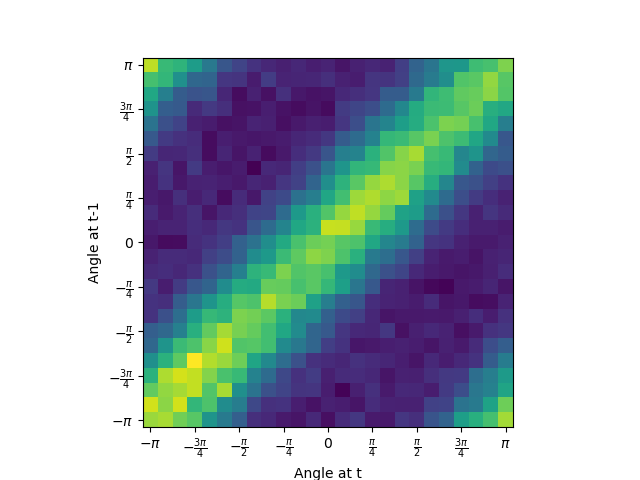

In [30]:
angle_histories = []
for i in range(250):
    x, y = np.random.uniform(-5, 5, 2)
    a = Walker(w=0.5, p=0.6, b=0.7, start=(x, y))
    path, angle_history = a.walk()
    angle_histories.append(np.array(angle_history)[:, None])
    
angle_histories = np.concatenate(angle_histories, axis=1)
a_tm1 = angle_histories[:-1, :].reshape(-1)
a_t = angle_histories[1:, :].reshape(-1)

n_bins = 25
bin_size = 2 * np.pi / n_bins
fig, ax = plt.subplots()
TM = np.histogram2d(a_tm1, a_t, bins=(n_bins, n_bins))[0]
plt.imshow(TM, aspect=1, origin='lower', extent=(-np.pi - bin_size / 2, np.pi + bin_size / 2, -np.pi - bin_size / 2, np.pi + bin_size / 2))
add_pi_ticks(ax, axis='both')
plt.xlabel('Angle at t')
plt.ylabel('Angle at t-1')
plt.show()